# synthetic validation


## 1. Real photocurrent, real PSCs

In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt


import subtractr
import subtractr.photocurrent_sim as pcsim
import subtractr.psc_sim as psc_sim
import jax.random as jrand

import circuitmap as cm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from subtractr import utils
from functools import partial
from jax import vmap

In [2]:
net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_500470/checkpoints/epoch=999-step=3125000.ckpt')
net = net.eval()

# Compare low-rank model to multi-trace model on simulated data

In [19]:
psc_amplitudes = np.arange(0.00, 0.5, 0.05)
low_rank_mse = np.zeros(len(psc_amplitudes))
network_mse = np.zeros(len(psc_amplitudes))
for i, amp in enumerate(psc_amplitudes):

    argstr = ("--num_train 10"
        " --linear_onset_frac 0.5"
        " --psc_scale_min %f --psc_scale_max %f"
        " --max_pc_fraction 0.5"
        " --onset_latency_ms 0.0 --num_test 100"
        " --num_traces_per_expt 160 --iid_noise_std_min 0.001"
        " --iid_noise_std_max 0.02" % (amp, amp))
    argstr = argstr.split(" ")
    args = subtractr.pc_subtractr_network.parse_args(argstr)

    dummy_net = subtractr.Subtractr(**vars(args))
    dummy_net.generate_training_data(args)

    # subtract photocurrent using trained net
    test_expts = dummy_net.test_expts
    ests = np.array([net(np.array(x)) for x in test_expts[0]])
    subtracted = test_expts[0] - ests
    true_pscs = test_expts[1]
    network_mse[i] = np.mean((subtracted - true_pscs)**2)


    # calculate mse using low-rank model
    ests = np.array([subtractr.low_rank.estimate_photocurrents_baseline(x,
        None, separate_by_power=False, stepwise_constrain_V=False) for x in test_expts[0]])
    subtracted = test_expts[0] - ests
    true_pscs = test_expts[1]
    low_rank_mse[i] = np.mean((subtracted - true_pscs)**2)



Running photocurrent removal...complete (elapsed time 0.35s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.37s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.35s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.36s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.34s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.33s, device=cpu).
Running photocurrent removal...complet

/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: invalid value encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/low_rank.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V_post = np.linalg.lstsq(U_stim, pscs_truncated)[0]


Running photocurrent removal...complete (elapsed time 0.45s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.39s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.37s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.39s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.40s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.40s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.40s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.38s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.37s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.39s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.39s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.38s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.38s, device=cpu).
Running photocurrent removal...complet

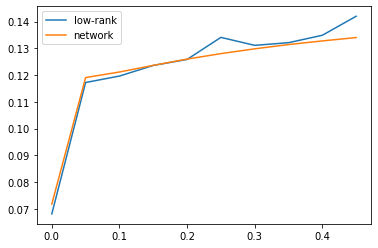

In [20]:
plt.plot(psc_amplitudes, low_rank_mse, label='low-rank')
plt.plot(psc_amplitudes, network_mse, label='network')
plt.legend()

In [18]:
np.arange(0.00, 0.5, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])